In [2]:
import numpy as np
import os

In [3]:
def fetch(url):
    import requests, gzip, os, hashlib, pathlib, numpy
    
    # fp = pathlib.Path.joinpath("/tmp" , hashlib.md5(url.encode('utf-8')).hexdigest() )
    fp = "C:/Users/Prarabdha/Desktop/TensorLabs.ai/tmp/" + hashlib.md5(url.encode('utf-8')).hexdigest()
    

    if os.path.isfile(fp):
        with open(fp , "rb") as f:
            data = f.read()
    else:
        with open(fp , "wb") as f:
            data = requests.get(url).content
            f.write(data) 
    return numpy.frombuffer(gzip.decompress(data) , dtype=np.uint8).copy()

X_train = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[0x10:].reshape((-1 , 28 , 28))
Y_train = fetch('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')[8:]
X_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')[0x10:].reshape((-1 , 28 , 28))
Y_test = fetch('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')[8:]

In [4]:
import torch
import torch.nn as nn
class PopNet(torch.nn.Module):
    def __init__(self):
        super(PopNet , self).__init__()
        self.l1 = nn.Linear(784 , 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128 , 10)

    def forward(self , x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x
    
model = PopNet()
model(torch.tensor(X_train[0:10].reshape((-1 , 28*28)) , dtype=torch.uint8).float())

tensor([[ 17.7175,  -2.5109,  16.0794,  57.8174,  -6.8587, -37.6468,  14.6488,
          21.4749,  -2.2508,   4.8947],
        [ 25.1036,   5.6166,  15.6108,  50.5806,  11.0723, -17.8364,  -9.6640,
           4.8065,  -1.9350,  -2.7081],
        [ 13.7928, -22.5641,  31.9711,  -0.2922,  -7.4183, -41.4554,  26.0515,
          15.0162,  -1.6996,  -0.8283],
        [ 32.6762,  12.1891,  -4.7245,   1.4505,  10.3297, -24.7787,   9.9130,
          20.9774,   0.4623,  -1.5807],
        [ 17.0705,  25.5907,  -1.0948,  29.1803,  13.3348, -35.2003,   1.6446,
           0.2262,   1.0121,   9.0263],
        [ 28.8947,  20.4277,  37.7445,  15.3588,   1.3162, -46.8521,  11.3122,
          24.2233, -10.7921,  -1.0653],
        [  8.2383,  -9.1651,  11.5856,  -8.5688,  34.7933, -37.9239,   9.5846,
           2.8408,  14.7374,  -1.4588],
        [ 38.9975,  38.8847,   6.5804,  40.1916,  -9.7347, -53.1660,  19.3069,
           7.2661, -11.9669,  20.2276],
        [  7.6149, -13.0793,  16.2112,  -9.3517,

In [5]:
from tqdm import tqdm
batch_size = 32
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
losses , accuracies = [] , []
for i in tqdm(range(1000)):
    samp = np.random.randint(0 , X_train.shape[0] , size = (batch_size))
    X = torch.tensor(X_train[samp].reshape((-1 , 28*28)) , dtype=torch.uint8).float()
    Y = torch.tensor(Y_train[samp] , dtype=torch.uint8).long()

    optim.zero_grad()
    out = model(X)
    cat = torch.argmax(out , dim=1)
    accuracy = (cat == Y).float().mean()

    loss = loss_function(out , Y)
    loss.backward()
    optim.step()
    loss , accuracy = loss.item() , accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
print(loss , accuracy)

  0%|          | 1/1000 [00:00<02:01,  8.25it/s]

100%|██████████| 1000/1000 [00:03<00:00, 333.00it/s]

0.28395575284957886 0.9375


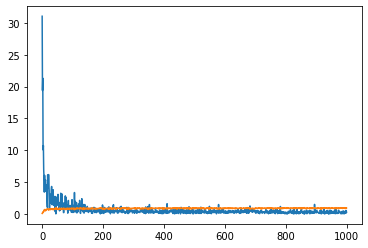

In [6]:
import matplotlib.pyplot as plt

# a = plt.subplot((1,2))
plt.plot(losses)
plt.plot(accuracies)

In [33]:
for i in tqdm(range(X_test.shape[0])):

    x = torch.tensor(X_test[i].reshape((-1 , 28*28)) , dtype=torch.uint8).float()
    y = torch.tensor(Y_test[i] , dtype=torch.uint8).long()
    out = model(x)
    cat = torch.argmax(out , dim=1)
    test_accuracy = (out == y).float().mean()

print(test_accuracy)

100%|██████████| 10000/10000 [00:03<00:00, 2685.67it/s]

tensor(0.)


In [7]:
l1 = np.zeros((28*28 , 128) , dtype=np.float32)
l2 = np.zeros((128 , 10) , dtype=np.float32)

In [8]:
import numpy
l1[ : ] = model.l1.weight.detach().numpy().transpose()
l2[:] = model.l2.weight.detach().numpy().transpose()

In [9]:
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x , 0)
    x = x.dot(l2)
    return x

print(forward(X_test.reshape((-1 , 28*28))))

[[-21.620028    -0.42961502  18.356297   ...  47.689487     8.167392
   15.527635  ]
 [ 13.584787     8.4042225   39.021446   ... -11.8134365   -4.171514
  -21.910734  ]
 [-13.879674    22.34408      7.145342   ...  11.325718     7.7449155
    9.573033  ]
 ...
 [  0.43647292   0.8231777    6.9321914  ...   8.707255     6.654086
   14.148972  ]
 [ -1.0596734   -1.3895136  -12.625152   ... -13.876163    10.983845
   -2.1184244 ]
 [ -1.7286456   -7.176779     7.4036274  ...  -3.5531936    6.8706574
   -5.910054  ]]


In [11]:
Y_test_preds_out = forward(X_test.reshape((-1 , 28*28)))
Y_test_preds = np.argmax(Y_test_preds_out , axis=1)
(Y_test_preds == Y_test).mean()

0.9231

In [12]:
ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]) , Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1))

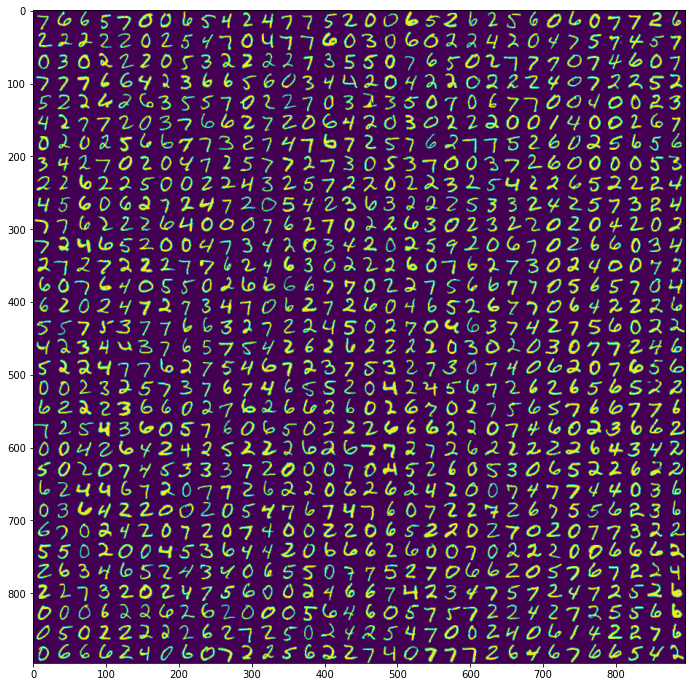

In [14]:

G=32
grid = sorted(list(zip(ret , range(ret.shape[0]))) , reverse=False)[0:G*G]
x_bad = X_test[[x[1] for x in grid]]
plt.figure(figsize=(12,12))
plt.imshow(np.concatenate(x_bad.reshape((G , 28*G , 28)) , axis=1))

In [46]:
samp = [0,1]

out = np.zeros((len(samp),10) , np.float32)
out[range(out.shape[0]) , Y_test[samp]] = 1

def logsumexp(x):
    c = x.max(axis=1)
    return c+np.log(np.exp(x-c.reshape((-1,1))).sum(axis=1))

def forward_backward(x,y):
    out = np.zeros((len(y),10) , np.float32)
    out[range(out.shape[0]) , y] = 1
    #forward pass
    # x = X_test[samp].reshape((-1 , 28*28))
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1 , 0)
    x_l2 = x_relu.dot(l2)
    x_lsm = x_l2 - np.log(np.exp(x_l2).sum(axis=1)).reshape((-1,1))
    x_loss = (-out * x_lsm).mean(axis=1)

    #backward pass

    d_out = -out/len(y)

    dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1,1))

    d_l2 = x_relu.T.dot(dx_lsm)
    dx_relu = dx_lsm.dot(l2.T)

    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

    d_l1 = x.T.dot(dx_l1)

    # plt.imshow(d_l1.T)
    # plt.figure(figsize=(12,12))
    # plt.imshow(d_l2.T)
    return x_loss , x_l2 , d_l1 , d_l2

samp= range(32)
forward_backward(X_test[samp].reshape((-1 , 28*28)) , Y_test[samp])


(array([3.62376795e-14, 9.63469539e-08, 7.30899121e-08, 7.51905023e-07,
        1.59394763e-06, 1.74775644e-07, 4.25997186e-03, 5.53770016e-04,
        2.96283341e-01, 1.24427207e-03, 3.36228823e-12, 2.65221619e-03,
        6.79461891e-06, 2.10062012e-10, 6.76436684e-13, 1.33419785e-05,
        3.26365270e-05, 2.13162821e-14, 2.94851273e-02, 8.35979819e-10,
        1.67165873e-03, 1.98951966e-14, 2.26663133e-13, 1.05190466e-07,
        1.56760322e-05, 7.00232564e-07, 1.27053957e-05, 1.12836155e-06,
        4.63984406e-13, 5.47587378e-07, 2.63451699e-04, 1.00756561e-06]),
 array([[ 2.36418823e+00, -1.27394811e+01,  3.37149014e+01,
          2.43494800e+01,  2.50645064e+01,  2.69046898e+01,
         -8.22138772e+01,  6.23634573e+01,  1.62651490e+01,
          2.34389037e+01],
        [-1.80556458e+01,  2.81892933e+01,  4.20420189e+01,
          7.24208366e+00, -1.87573705e+01,  1.37851046e+01,
         -3.16611155e+00, -9.30763262e+00,  1.37805135e+01,
         -1.80963171e+01],
        

100%|██████████| 1000/1000 [00:02<00:00, 359.54it/s]

0.0076063527 0.9765625


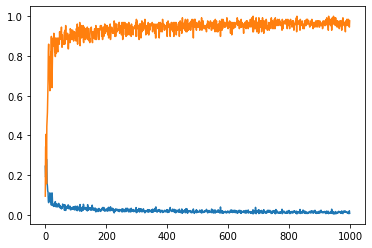

In [56]:
#numpyb training

def kaiming(m,h):
    ret = np.random.uniform(-1./np.sqrt(m*h) , 1./np.sqrt(m*h) , size = (m,h))
    return ret.astype(np.float32)

#init
lr = 0.001
l1 = kaiming(*l1.shape)
l2 = kaiming(*l2.shape)

BS = 128
losses , accuracies = [] , []
for i in tqdm(range(1000)):
    samp = np.random.randint(0 , X_train.shape[0] , size=(BS))
    X = X_train[samp].reshape((-1 , 28*28))
    Y = Y_train[samp] 
    x_loss , x_l2 , d_l1 , d_l2 = forward_backward(X,Y)

    l1 = l1 - lr*d_l1
    l2 = l2 - lr*d_l2
    cat = np.argmax(x_l2 , axis=1)
    accuracy = (cat==Y).mean()

    loss = x_loss.mean()
    losses.append(loss)
    accuracies.append(accuracy)

print(loss , accuracy)
plt.plot(losses)
plt.plot(accuracies)